In [33]:
import json
import pandas as pd
import numpy as np
from numpy import inf
import requests
from io import BytesIO
from PIL import Image
from IPython.display import display
import textdistance
import time
from glob import glob
from sklearn.metrics import classification_report, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import os
from preprocess import Preprocess

In [34]:
class SEARCH_RECOMMEND:
    
    def __init__(self, df, qval=None, style_ths=0.1):

        self.style_ths_str = str(style_ths)[-1]
#         self.compare_y = False
        self.df = df
        self.qval = qval  # Q-Value : 거리 유사도 알고리즘에서 q-gram 으로 문장을 어떻게 나눌지 결정하는 파라미터 (None:단어기반, 1:철자기반, 2~more:q-gram)
        self.df_ = self.preprocess_df(self.df)  # new_tag feature를 새롭게 추가 전처리
        self.user_item_set = set()  # 사용자가 아이템을 선택(검색/추천)시 => 사용자가 선택한 아이템 목록
        self.cold_start = True   # Cold Start : 최적화된 추천 알고리즘 선택을 위해 사용자의 아이템 목록이 비어있는지 확인하는 변수
        
    def preprocess_df(self, df):
        # make new-tag
        # top3_style, tags, name, projectId 를 하나의 string으로 만들기
        df['new_tag'] = list(
                            zip(
                                df[f'top_style_{self.style_ths_str}'].tolist(), 
                                df['tags'].tolist(),
                                df['name'].tolist(),
                                df['projectId'].tolist()
                                )
                            )
        df['new_tag'] = df['new_tag'].apply(self.reduce_newtag)
        df['new_tag'] = df['new_tag'].apply(lambda x: ' '.join(x).lower())
        return df
    
    def reduce_newtag(self, x):
        newtag = []
        for tag in x:
            if type(tag) == str:
                newtag.append(tag)
            else:
                newtag.extend(tag)
        return newtag
    
    # 사용자 셋에 아이템 추가
    def add_item_in_user_item_set(self, prod):
        print(f'사용자 님의 아이템 목록에 [{prod}]를 추가합니다.')
        id_ = self.df_[self.df_['name'] == prod]['product_id'].values[0]
    ##
        cat_ = self.df_[self.df_['name'] == prod]['category'].values[0]
        self.user_item_set.add((id_, cat_))
    ##
        self.cold_start = False
        print(f'사용자 님이 현재 선택한 아이템 목록 : {self.user_item_set}')
        return id_
    
    # 사용자 셋에서 아이템 제거
    def remove_item_from_user_item_set(self, prod):
        print(f'사용자 님의 아이템 목록에서 [{prod}]를 제거합니다.')
        id_ = self.df_[self.df_['name'] == prod]['product_id'].values[0]
    ##
        cat_ = self.df_[self.df_['name'] == prod]['category'].values[0]
        self.user_item_set.remove((id_, cat_))
    ##
        print(f'사용자 님의 현재 남아있는 선택된 아이템 목록 : {self.user_item_set}')
        # 사용자 목록이 비게 되면 콜드스타트
        if len(self.user_item_set) > 1:
            self.cold_start = True
    
    # 사용자가 선택한 아이템과 데이터 내 모든 아이템들과의 유사도 계산
    def get_similarity_score(self, search_prod_tag, algo='sorensen'):
        """
        search_prod_tag : string, 사용자가 선택한 아이템 이름으로부터 매칭된 self.df_['new_tag'].values
        """
        # calculate similarity
        sim_score = []
        new_tag = self.df_['new_tag'].tolist()
        start_time = time.time()
        for i, tag in enumerate(new_tag):
            if algo == 'sorensen':
                sim_score.append(textdistance.Sorensen(qval=self.qval, as_set=True).normalized_similarity(search_prod_tag, tag))
            elif algo == 'ncd':
                sim_score.append(textdistance.EntropyNCD(qval=self.qval).normalized_similarity(search_prod_tag, tag))
        print(f'검색 태그 : {search_prod_tag}')
        print(f'검색 시간 : {round(time.time()-start_time, 4)}초')
        print()
        return sim_score
    
############## [2022-03-13 : 유치영] - 평가지표 구하기 위해 프로젝트 아이디 추출
    def add_projectId(self, projectId):
        project_id = []
        project_id.append(projectId)
        return project_id
    
    # 사용자 선택한 아이템/아이템 목록으로부터 유사도를 통해 아이템 추천
    def search_product(self, prod, topn=10, algo='sorensen'):
        """
        prod : string, 아이템 이름
        topn : int, 유사도 상위 n개의 아이템 추천
        algo : 'sorensen' - 토큰 기반 거리 유사도 알고리즘, 'ncd' - 문장 압축을 통한 유사도 알고리즘
        """
        # 아이템을 사용자 아이템 목록에 추가
        # declare id, category of searching product
        id_ = self.add_item_in_user_item_set(prod)
        prod_cat = self.df_[self.df_['product_id'] == id_]['category'].values[0]
        # if prod_cat == np.nan:
        #     prod_cat = self.df_[self.df_['product_id'] == id_]['category_b'].values[0]
        #     self.compare_y = True
        
############## [2022-03-13 : 유치영] - 평가지표 구하기 위해 프로젝트 아이디 추출
        print(f"검색 아이템이 해당한 프로젝트 ID : {self.add_projectId(self.df_[self.df_['name'] == prod]['projectId'].values[0])}")
        
        if self.cold_start:
            # retrieve the product tag from the input product id
            # 동일 아이템이 여러 전문가에 사용될 경우 => awesome_score 가 더 높은 점수를 받은 아이템의 new_tag를 가져옴
            search_prod_tag = self.df_[self.df_['product_id'] == id_].sort_values(by='awesome_score', ascending=False)['new_tag'].values[0]
        else:
            search_prod_tag = ''
            for existing_item_id, _ in self.user_item_set:
                temp_id = self.df_[self.df_['product_id'] == existing_item_id].sort_values(by='awesome_score', ascending=False)['new_tag'].values[0]
                search_prod_tag += temp_id+' '
            search_prod_tag = search_prod_tag[:-1]
            
        # 해당 아이템-다른 아이템 간 유사도 계산
        sim_score = self.get_similarity_score(search_prod_tag, algo=algo)
        
        # save result
        sim_score = np.asarray(sim_score)  # [사용자가 선택한 아이템-다른 모든 아이템] 간 유사도 점수
        sim_score_idx = np.arange(len(sim_score)) # 유사도 점수에 대한 인덱스
        
        result_df = self.df_.iloc[sim_score_idx][['product_id', 'name', 
                                                  'new_tag', 'projectId', 
                                                  'images', 'category']]
        result_df['similarity'] = sim_score
        
        # filtering
        result_df = result_df[result_df['product_id']!=id_]  # 사용자가 선택한 아이템과 동일한 아이템 제거
        result_df = result_df.drop_duplicates(['product_id'])  # 중복된 아이템 제거
        
    ## [2022-03-12 : 이루오] - 추가된 코드 시작
        # 사용자가 이미 선택한 아이템들은 추천목록에서 제거
        if len(self.user_item_set) > 1:
            print("!!사용자가 이미 선택한 아이템, 같은 카테고리 아이템들은 추천목록에서 제거!!")
            for existing_item_id, existing_item_cat in self.user_item_set:
                result_df = result_df[result_df['product_id']!=existing_item_id]
                result_df = result_df[result_df['category']!=existing_item_cat]
                
    ## [2022-03-12 : 이루오] - 추가된 코드 끝
    
        result_df = result_df[result_df['category'] != prod_cat] 
        result_df = result_df.sort_values(by='similarity', ascending=False).reset_index()[:topn] # 유사도가 가장 높은 순서대로 정렬 => top-n개 까지 추천 결과 저장
        
        # show result image
        print(f'사용자가 선택한 아이템 : {prod}')
        try:
            prod_res = requests.get(self.df_[self.df_['name'] == prod]['images'].values[0][0])
            display(Image.open(BytesIO(prod_res.content)))
        except:
            print('이미지 없음\n')
            print()

        print("="*80)
        print(f"추천 아이템 Top{topn}")
        print("="*80)
        
        i = 1
        for name, img_url in result_df[['name', 'images']].values:
            print(f"추천 {i}순위 : {name}")
            try:
                res = requests.get(img_url[0])
                img = Image.open(BytesIO(res.content))
                display(img)
            except:
                print('이미지 없음\n')
            print("-"*60)
            i += 1
        self.result = result_df
############## [2022-03-13 : 유치영] - 평가지표 구하기 위해 프로젝트 아이디 추출
        project_id = self.add_projectId(self.df_[self.df_['name'] == prod]['projectId'].values[0])
        self.projectId = project_id

In [35]:
base_bath = '2022-03-07/'
# abs path -> 2022-03-07/ *.json
best = glob(base_bath+'best*.json')
item = glob(base_bath+'item*.json')
products = glob(base_bath+'products*.json')
#category1 == category2 = True
category = glob(base_bath+'category1.json')

In [36]:
best, item, products, category

(['22-03-07\\bestshots1.json', '22-03-07\\bestshots2.json'],
 ['22-03-07\\items1.json', '22-03-07\\items2.json'],
 ['22-03-07\\products1.json', '22-03-07\\products2.json'],
 ['22-03-07/category1.json'])

In [37]:
# 데이터전처리 클래스로부터 객체 선언하기
# style_ths = 0.1
# style_ths_str = str(style_ths)[-1]
st = time.time()
DATA = Preprocess(best, item, products, category)
print(f"{time.time()-st}초")

C:\Users\jumpx\Downloads\new\new\preprocess.py:86: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  items_stack = pd.DataFrame(templates['items'].apply(lambda x: pd.Series(x)).stack()).reset_index(1, drop=True)


3.67271089553833초


In [38]:
best_item_df, products_df_4, products_df_b = DATA.best_item, DATA.products_4, DATA.products_b
best_item_df.shape, products_df_4.shape, products_df_b.shape

((4556, 38), (10802, 12), (170567, 12))

In [39]:
for item_name in products_df_b.name.tolist():
    if '책상' in item_name:
        print(item_name)
        break

위더스 멀티책상 1460 화이트에디션 (화이트)


In [40]:
# qval=None => 아이템과 유사한 카테고리의 결과 추천 / qval=int => 아이템과 비슷한 스타일의 다른 아이템 추천(기존 전문가 셋을 기반)
search_engine_b = SEARCH_RECOMMEND(products_df_b, qval=3)

사용자 님의 아이템 목록에 [위더스 멀티책상 1460 화이트에디션 (화이트)]를 추가합니다.
사용자 님이 현재 선택한 아이템 목록 : {('Xz-wADS1233D0271CF94C97', '책상/테이블')}
검색 아이템이 해당한 프로젝트 ID : ['x8leutv16a82efbbf284125']
검색 태그 : modern 소프시스 위더스 멀티책상 1460 화이트에디션 (화이트) x8leutv16a82efbbf284125
검색 시간 : 12.883초

사용자가 선택한 아이템 : 위더스 멀티책상 1460 화이트에디션 (화이트)


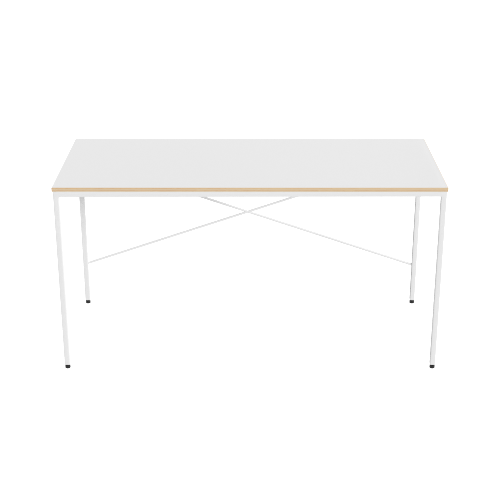

추천 아이템 Top30
추천 1순위 : 또띠 인테리어 체어 의자 (화이트)


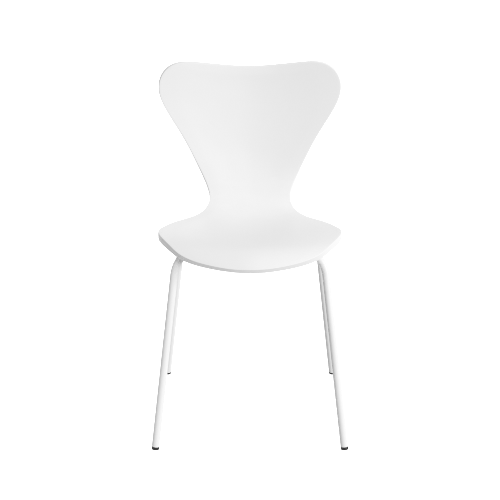

------------------------------------------------------------
추천 2순위 : 일반용 평판 걸레받이 몰딩 8cm_오크


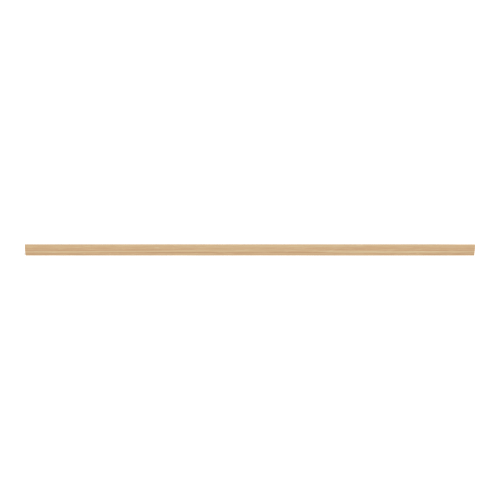

------------------------------------------------------------
추천 3순위 : 프라하 커튼 (묶임) 긴창커튼 1폭(스카이)


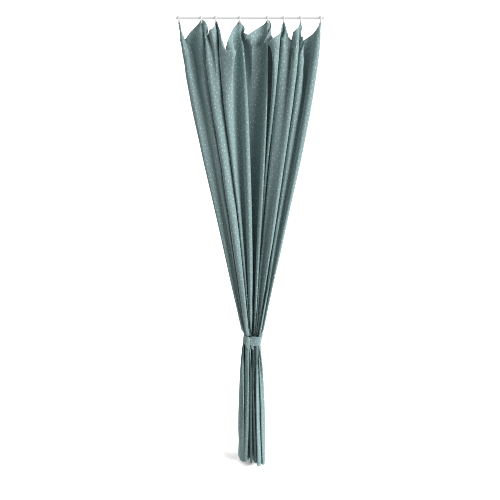

------------------------------------------------------------
추천 4순위 : 모아나 아쿠아텍스 3인용 소파(스툴포함) (라이트그레이)


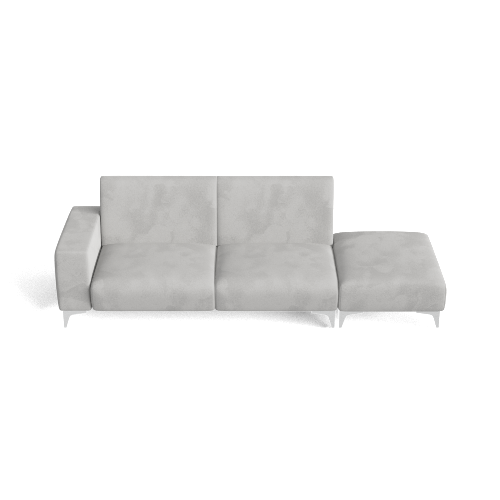

------------------------------------------------------------
추천 5순위 : 무이 1등 단스탠드 (베이지 레드)


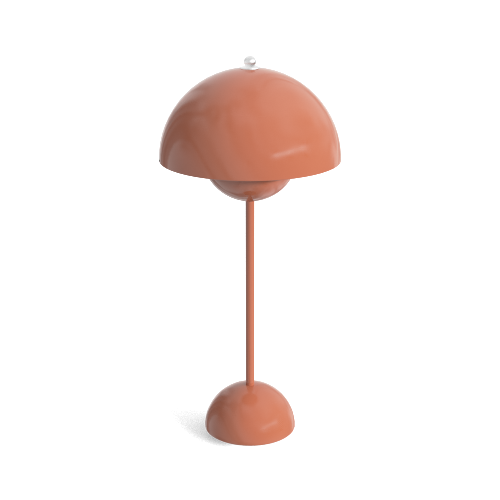

------------------------------------------------------------
추천 6순위 : 위더스 데코 코너선반 (화이트)


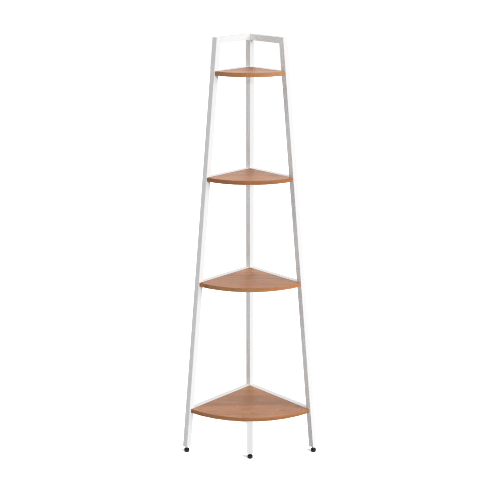

------------------------------------------------------------
추천 7순위 : 파티션 (화이트)


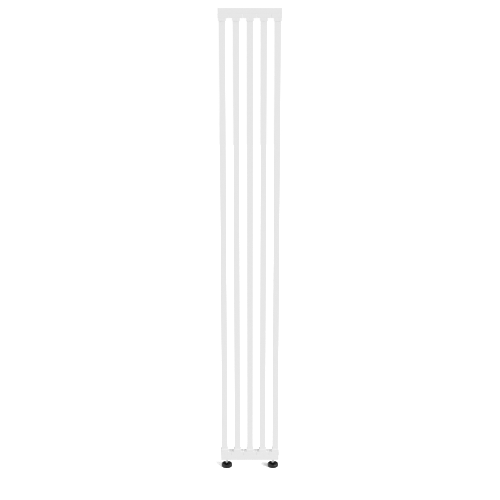

------------------------------------------------------------
추천 8순위 : 모던 상부장 (화이트)


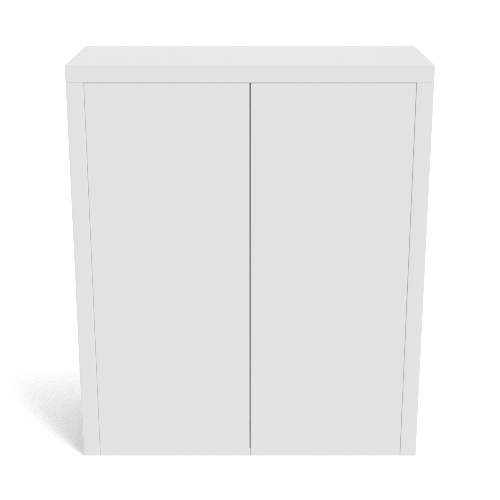

------------------------------------------------------------
추천 9순위 : 샘키즈 스칸디 에디션 전면책장 870 (화이트)


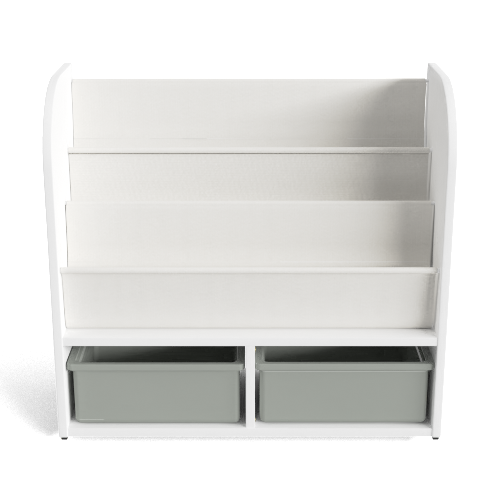

------------------------------------------------------------
추천 10순위 : 가방형 LP턴테이블 (화이트)


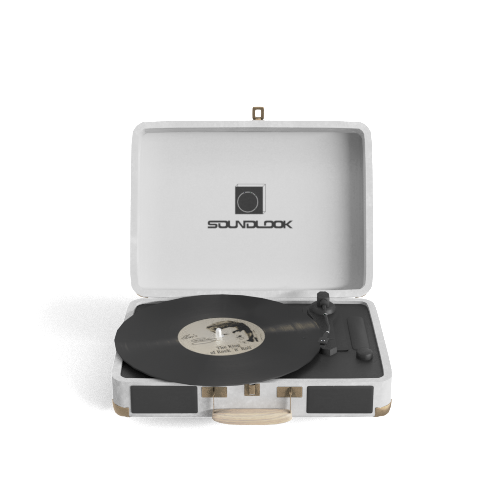

------------------------------------------------------------
추천 11순위 : 욕실 벽면타일 (화이트)


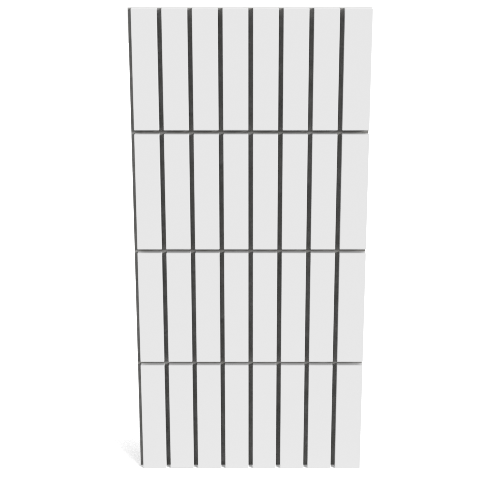

------------------------------------------------------------
추천 12순위 : 모던 하부장 1 (화이트)


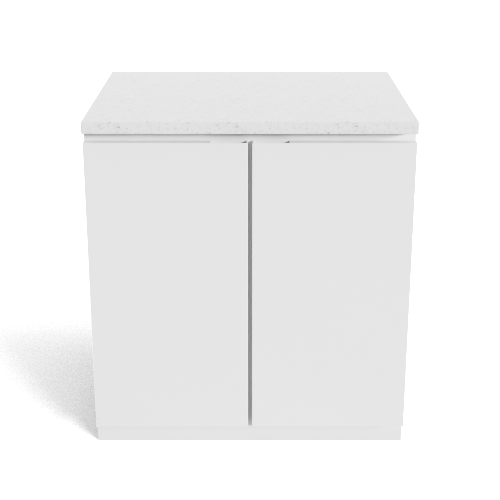

------------------------------------------------------------
추천 13순위 : 나무손잡이 싱크 (화이트)


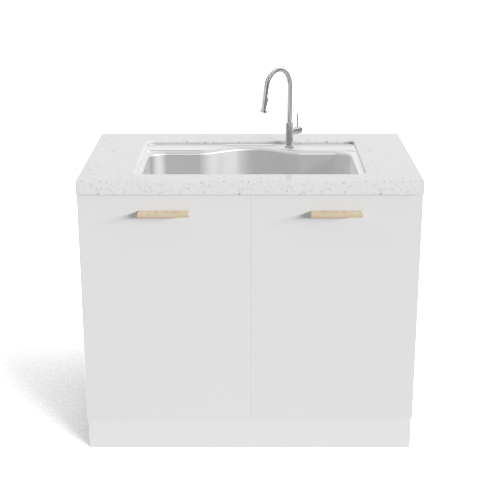

------------------------------------------------------------
추천 14순위 : 벽 장식 파티션 (화이트)


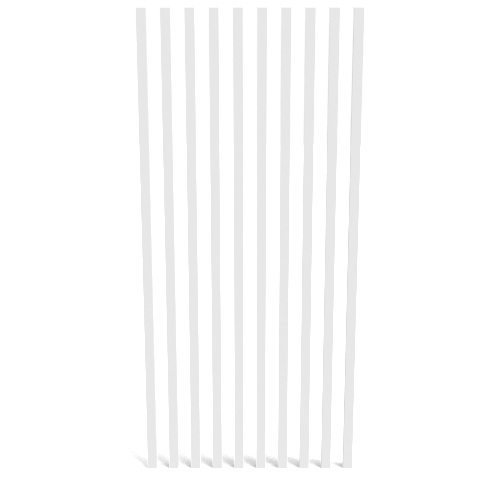

------------------------------------------------------------
추천 15순위 : 휘게체어 (화이트)


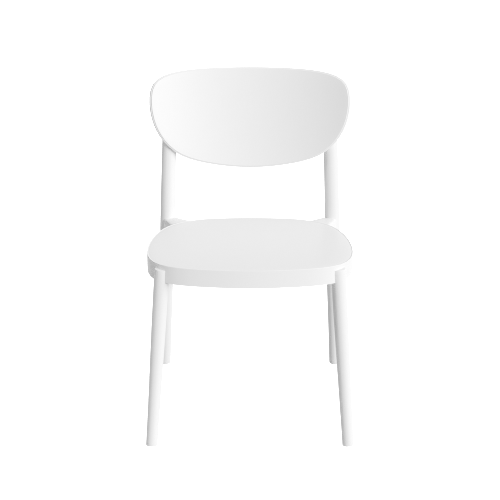

------------------------------------------------------------
추천 16순위 : 1968 레트로 스탠드 (화이트)


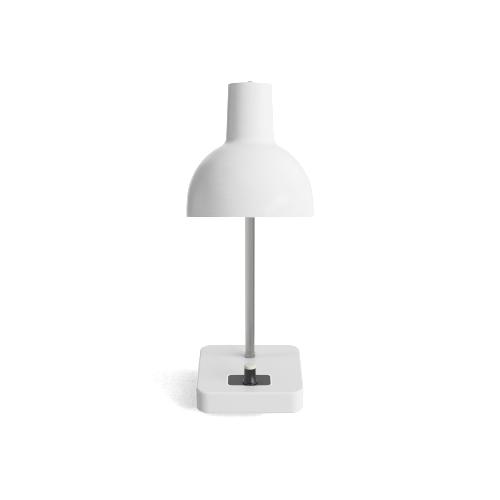

------------------------------------------------------------
추천 17순위 : 무소음모던화이트스탠드시계 (화이트)


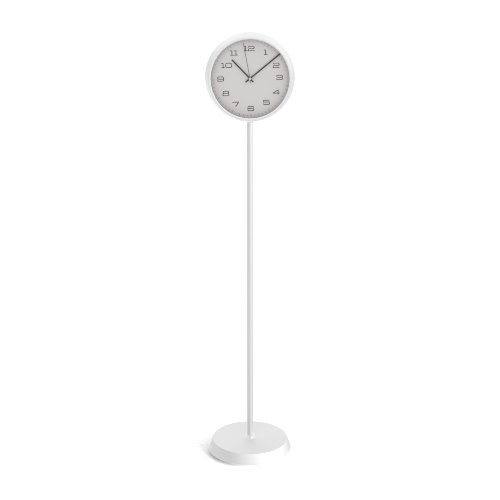

------------------------------------------------------------
추천 18순위 : 싱크대 상+하부장 세트 (투도어) (화이트)


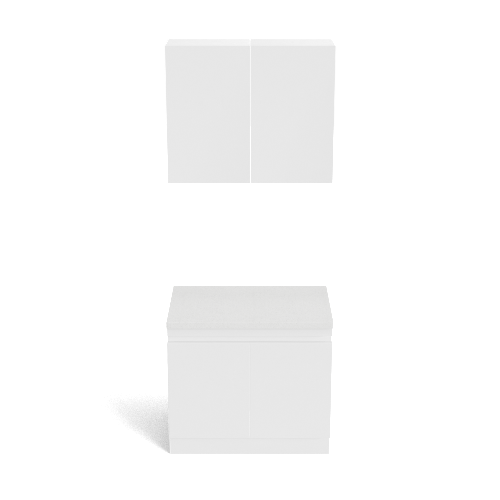

------------------------------------------------------------
추천 19순위 : 키 큰장 (화이트)


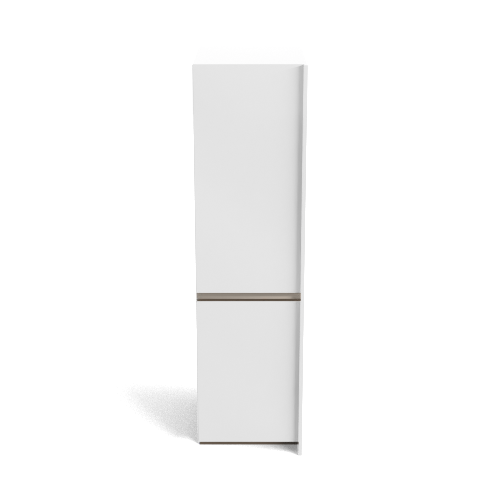

------------------------------------------------------------
추천 20순위 : 레트로 스탠드 (화이트)


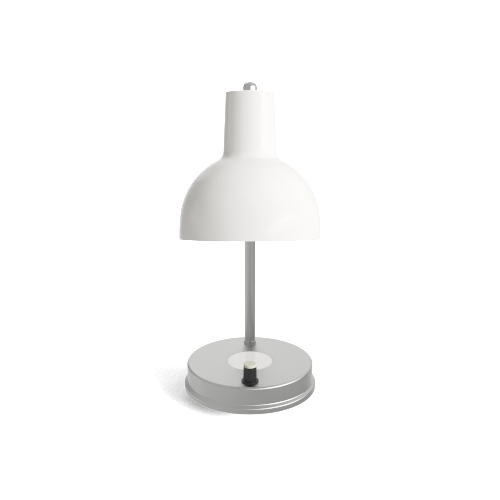

------------------------------------------------------------
추천 21순위 : 스노우트롤리 멀티 트롤리행거 (화이트)


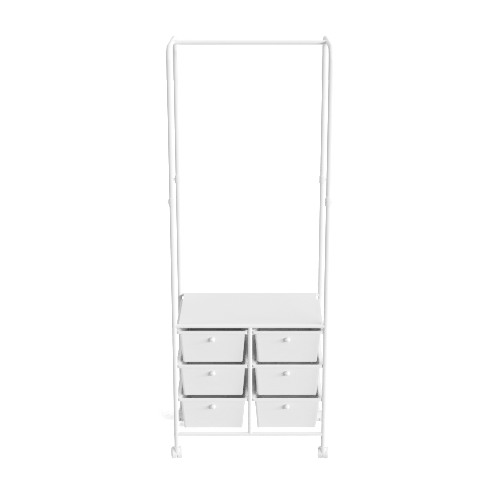

------------------------------------------------------------
추천 22순위 : 자주 쓰는 슬림 가스버너 (화이트)


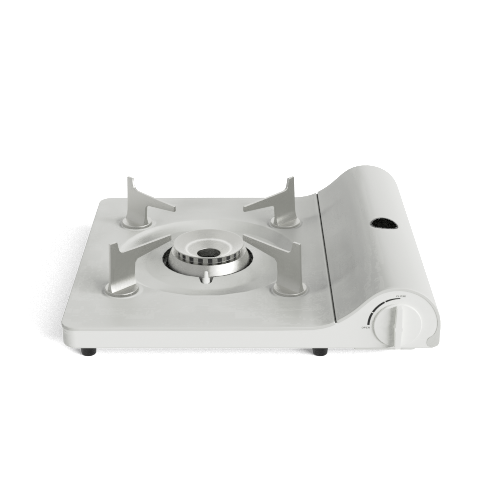

------------------------------------------------------------
추천 23순위 : 레시피 왕5단서랍장 (화이트)


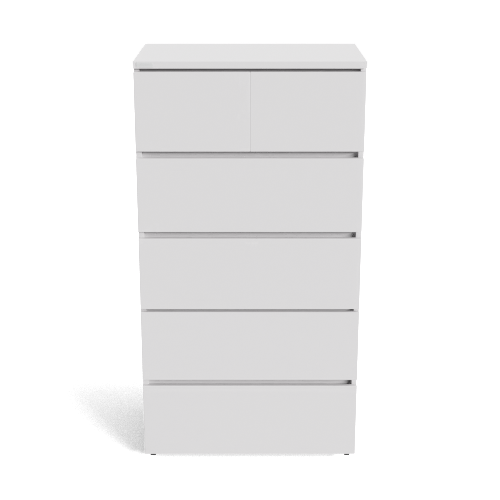

------------------------------------------------------------
추천 24순위 : 틴우드 유리 철제파티션 1200 (하프) (화이트)


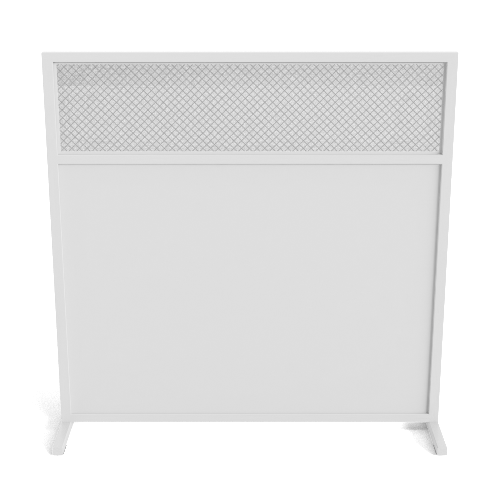

------------------------------------------------------------
추천 25순위 : 틴우드 타공판 철제파티션 800 (하프) (화이트)


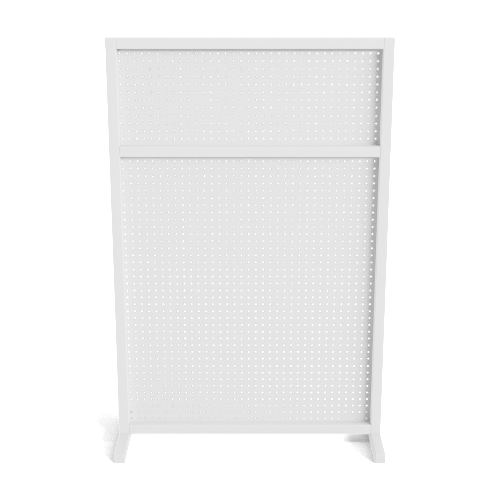

------------------------------------------------------------
추천 26순위 : LED 바니바니 무드등 화이트 (대)


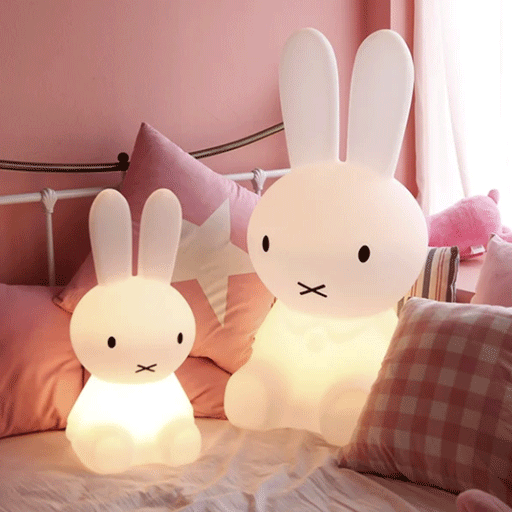

------------------------------------------------------------
추천 27순위 : 플리츠 세라믹화병 (화이트)


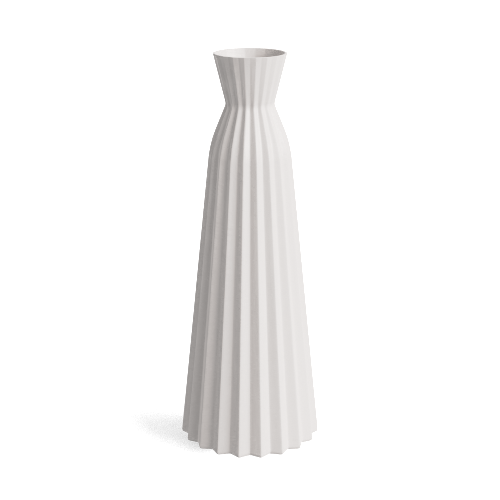

------------------------------------------------------------
추천 28순위 : 빈티지 싱크 (화이트)


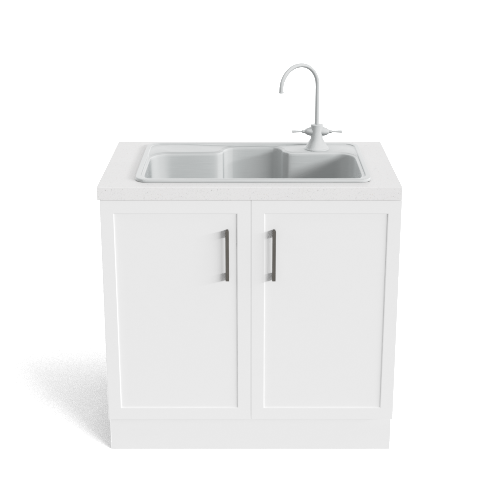

------------------------------------------------------------
추천 29순위 : 쉘체어 실버다리 (화이트)


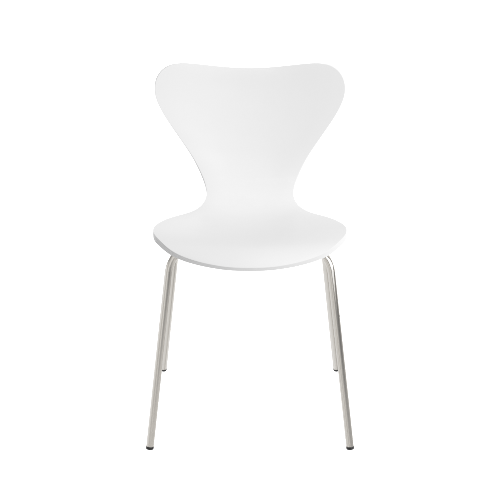

------------------------------------------------------------
추천 30순위 : 다용도 매직 파티션 M (화이트)


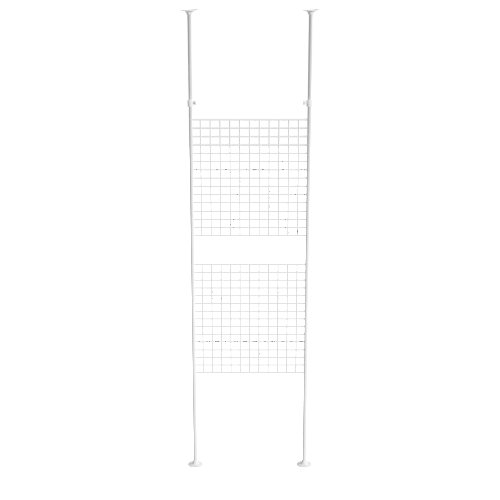

------------------------------------------------------------


In [41]:
prod = '위더스 멀티책상 1460 화이트에디션 (화이트)'
search_engine_b.search_product(prod, topn=30)

In [42]:
result = search_engine_b.result

In [43]:
project_id = search_engine_b.projectId

In [44]:
project_id

['x8leutv16a82efbbf284125']

In [14]:
def average(project_id,products_df, result):
    results = []
    project_product = []
    for i in range(len(project_id)):
        # products_df에서 검색한 프로젝트 아이디를 찾고 프로젝트 아이디가 가지고 있는 아이템들을 list로 가져오기
        project_products_id = products_df[products_df['projectId'] == project_id[0]]['product_id'].tolist()
        #result(추천해준 제품들) 리스트 업
        result_product_id = result['product_id'].tolist()
        for j in range(len(result_product_id)):
            # 해당 제품의 프로젝트 아이디가 가지고 있는 아이템 중 추천한 아이템이 들어있는가 
            if result_product_id[j] in project_products_id:
                # 들어있으면 1
                result_product_id[j] = 1
            else:
                # 없으면 0
                result_product_id[j] = 0
        results.append(result_product_id)
        project_product.append(project_products_id)
    # return results, project_product
    return f'선택한 프로젝트 아이템이 들어있는 비율 : {round(sum(result_product_id)/len(result_product_id), 3)}  다른 프로젝트 아이템이 들어있는 비율 : {round(1 - (sum(result_product_id)/len(result_product_id)), 3)}'

In [15]:
average(project_id, products_df_b, result)

'선택한 프로젝트 아이템이 들어있는 비율 : 0.167  다른 프로젝트 아이템이 들어있는 비율 : 0.833'

In [16]:
from sklearn.metrics import dcg_score, ndcg_score
# rank = [[1, 2, 3, ...]]
# score = [[ .. .. .. ]]
rank = [np.arange(1, len(result)+1).tolist()]
score = [result['similarity'].values.tolist()]

#ignore_ties -> 예측 된 값들 중복 포함 여부 
print(f'dcg_score : {dcg_score(rank, score, ignore_ties=True)}')
print(f'dcg_score 중복 포함: {dcg_score(rank, score)}')
print(f'Ndcg_score : {ndcg_score(rank, score, ignore_ties=True)}')
print(f'Ndcg_score 중복 포함: {ndcg_score(rank, score)}')

dcg_score : 112.15967226638534
dcg_score 중복 포함: 112.17004529391895
Ndcg_score : 0.6525869897806554
Ndcg_score 중복 포함: 0.6526473439407228


In [17]:
products_df_4.pivot_table(index='category', columns='projectId')

awesome_score                          \
projectId    x0h30vi6b2160aa050d4de6 x0ig1ra86a5ae1149b44a46   
category                                                       
Appliances                       NaN                     NaN   
Bathroom                    0.805037                     NaN   
Bedroom                          NaN                     NaN   
Chairs                           NaN                     NaN   
Construction                     NaN                     NaN   
Décor                            NaN                     NaN   
Kitchen                          NaN                0.879942   
Lighting                         NaN                     NaN   
Outdoor                          NaN                     NaN   
Sofas                            NaN                     NaN   
Storage                          NaN                     NaN   
Tables                           NaN                     NaN   

                                                              \
projectId    x0m_qot0c0bd0cc31d6401a x0ntnsv80f53e9104804254   
category                                                       
Appliances                       NaN                     NaN   
Bathroom                    0.933364                     NaN   
Bedroom                          NaN                     NaN   
Chairs                           NaN                     NaN   
Construction                     NaN                     NaN   
Décor                            NaN                     NaN   
Kitchen                     0.934589                0.926417   
Lighting                         NaN                     NaN   
Outdoor                          NaN                     NaN   
Sofas                            NaN                     NaN   
Storage                          NaN                     NaN   
Tables                           NaN                     NaN   

                                                              \
projectId    x0o0rf7e5c4a9b3ba714c83 x0ow_9n24b18f53efeb4ab6   
category                                                       
Appliances                       NaN                     NaN   
Bathroom                         NaN                     NaN   
Bedroom                          NaN                     NaN   
Chairs                           NaN                0.953083   
Construction                     NaN                     NaN   
Décor                       0.817221                0.953083   
Kitchen                     0.817221                0.953083   
Lighting                    0.817221                0.953083   
Outdoor                          NaN                     NaN   
Sofas                            NaN                     NaN   
Storage                          NaN                     NaN   
Tables                           NaN                0.953083   

                                                              \
projectId    x0singo0e0950b8ab924485 x0ywx86a06e14d6390f41fc   
category                                                       
Appliances                       NaN                     NaN   
Bathroom                         NaN                     NaN   
Bedroom                          NaN                     NaN   
Chairs                           NaN                     NaN   
Construction                     NaN                     NaN   
Décor                            NaN                     NaN   
Kitchen                     0.886771                0.878161   
Lighting                         NaN                     NaN   
Outdoor                          NaN                     NaN   
Sofas                            NaN                     NaN   
Storage                          NaN                     NaN   
Tables                           NaN                     NaN   

                                                              ...  \
projectId    x1nutfx857bbab86d92406b x1v5fim9cc57c078d7b410c  ...   
category                                 

In [18]:
def sparse_matrix(products_df, result):
    # project 마다 item별 awesome_score 를 값으로 줘서 값이 존재하면 1 존재하지않으면 0
    train = products_df.pivot_table('awesome_score', index='category', columns='projectId').fillna(0).round().astype(int).T
    
    #나눠준 프로젝트마다 describe를 진행해 카테고리 별 몇개의 아이템을 사용했는지 평균을 구함 code -> x_train.describe().T['mean']
    # 그 평균을 np.percentile을 진행해서 mean 값들의 70%에 해당하는 값보다 크면 1 작으면 0 으로 
    # 가장 많이 등장하는 아이템들로 target을 선정 = code -> .apply(lambda x: 1 if x > np.percentile(x_train.describe().T['mean'], 70) else 0).reset_index(drop='name_x')
    train = train.describe().T['mean'].apply(lambda x: 1 if x > np.percentile(train.describe().T['mean'], 40) else 0).reset_index(drop='name_x')

    # 새로운 프레임(columns=category)
    frame = pd.DataFrame(columns=products_df.pivot_table('awesome_score',
                                                       index='category',
                                                        columns='projectId').fillna(0).round().astype(int).T.columns,index=['user']).fillna(0)
    # 추천 해준 category 이름으로 unique 적용
    # 추천 해준 아이템 카테고리가 frame 존재 하면 1 없으면 0
    for i in result['category'].unique().tolist():
        if i in frame.columns:
            frame[i] = 1
        else:
            0
    # 예측 된 값과 추천 해준 값을 비교 
    print(classification_report(frame.iloc[0].values, train.values))
    # Average_precision이 높으면 가장 많은 카테고리를 추천 해주기에 50%대가 적절함
    print('Average_Precision : ',average_precision_score(frame.iloc[0].values, train.values))
    print('')
    return f'사용된  아이템 :{train.values}','------', f'추천해준 아이템 :{frame.iloc[0].values}'

In [19]:
sparse_matrix(products_df_b, result)

              precision    recall  f1-score   support

           0       0.43      0.50      0.46         6
           1       0.73      0.67      0.70        12

    accuracy                           0.61        18
   macro avg       0.58      0.58      0.58        18
weighted avg       0.63      0.61      0.62        18

Average_Precision :  0.7070707070707071



('사용된  아이템 :[1 0 0 0 0 1 1 0 1 1 0 1 1 1 0 1 1 1]',
 '------',
 '추천해준 아이템 :[1 1 0 0 0 1 1 1 1 1 1 0 1 0 1 1 1 0]')

In [23]:
train = products_df_b.pivot_table('awesome_score', index='category', columns='projectId').fillna(0).round().astype(int).T
train_df = train.describe().T['mean'].apply(lambda x: 1 if x > np.percentile(train_4.describe().T['mean'], 40) else 0).reset_index(drop='name_x')
train_df.values

array([1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [24]:
train.describe().T['mean'].sort_values(ascending=False).values

array([0.74515152, 0.73484848, 0.72393939, 0.68333333, 0.64575758,
       0.59666667, 0.46363636, 0.41909091, 0.37333333, 0.24333333,
       0.23151515, 0.21363636, 0.20181818, 0.18636364, 0.12818182,
       0.06787879, 0.03666667, 0.00787879])

In [25]:
np.percentile(train.describe().T['mean'].sort_values(ascending=False).values, 50)

0.30833333333333335

In [26]:
frame = pd.DataFrame(columns=products_df_b.pivot_table('awesome_score',
                                                       index='category',
                                                       columns='projectId').fillna(0).round().astype(int).T.columns,
                    index=['user']).fillna(0)
frame

category  가전  드레스룸/행거  문/창문  반려동물  생활/운동  소파  수납가구  유아동가구  의자/스툴  조명  주방싱크/욕실  \
user       0        0     0     0      0   0     0      0      0   0        0   

category  책상/테이블  책장/선반  침대/매트리스  파티션/구조물  패브릭  홈데코  화장대/거울  
user           0      0        0        0    0    0       0

In [27]:
frame.columns

Index(['가전', '드레스룸/행거', '문/창문', '반려동물', '생활/운동', '소파', '수납가구', '유아동가구',
       '의자/스툴', '조명', '주방싱크/욕실', '책상/테이블', '책장/선반', '침대/매트리스', '파티션/구조물',
       '패브릭', '홈데코', '화장대/거울'],
      dtype='object', name='category')

In [28]:
for i in result['category'].unique().tolist():
    if i in frame.columns:
        frame[i] = 1
    else:
        0

In [29]:
frame.iloc[0].values

array([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0], dtype=int64)

In [30]:
result['category'].unique().tolist()

['의자/스툴',
 '파티션/구조물',
 '패브릭',
 '소파',
 '조명',
 '책장/선반',
 '주방싱크/욕실',
 '유아동가구',
 '가전',
 '홈데코',
 '드레스룸/행거',
 '수납가구']

In [31]:
products_df_4['category'].unique()

array(['Décor', 'Kitchen', 'Lighting', 'Tables', nan, 'Chairs', 'Bedroom',
       'Appliances', 'Bathroom', 'Storage', 'Sofas', 'Construction',
       'Outdoor'], dtype=object)

In [32]:
products_df_b['category'].unique()

array(['가전', '소파', '패브릭', '홈데코', '책상/테이블', '침대/매트리스', '책장/선반', '조명',
       '화장대/거울', '수납가구', '의자/스툴', '파티션/구조물', '드레스룸/행거', '주방싱크/욕실',
       '생활/운동', '유아동가구', nan, '반려동물', '문/창문'], dtype=object)